<center>

# Football Analytics - Player Shots in Competition

Neste notebook iremos explorar chutes de um jogador selecionado em uma competição inteira selecionada.  

## IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from urllib.request import urlopen
from mplsoccer import Sbopen, Pitch, FontManager, VerticalPitch, add_image
from PIL import Image
from statsbombpy import sb

In [3]:
# Ajustar as configurações de exibição
pd.set_option('display.max_columns', None)  # None permite mostrar todas as colunas

## EXTRAINDO AS COMPETIÇÕES E TEMPORADAS DISPONÍVEIS

In [4]:
competitions = sb.competitions()
competitions.head(3)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825


In [5]:
# Criando uma lista com todas competições e seus respectivos ids, ordenadas de forma alfabética
competitions_list = competitions[['competition_name', 'competition_id']].drop_duplicates().reset_index(drop=True)

competitions_list

,competition_name,competition_id
0,1. Bundesliga,9
1,African Cup of Nations,1267
2,Champions League,16
3,Copa America,223
4,Copa del Rey,87
5,FA Women's Super League,37
6,FIFA U20 World Cup,1470
7,FIFA World Cup,43
8,Indian Super league,1238
9,La Liga,11


In [6]:
# Criando uma lista com todas as temporadas listadas da mais recente para a mais antiga
seasons_list = competitions[['season_name', 'season_id']].sort_values(by='season_name', ascending=False).drop_duplicates().reset_index(drop=True)

seasons_list

,season_name,season_id
0,2024,282
1,2023/2024,281
2,2023,107
3,2022/2023,235
4,2022,106
5,2021/2022,108
6,2020/2021,90
7,2020,43
8,2019/2020,42
9,2019,30


## SELECIONANDO COMPETIÇÃO E TEMPORADA

In [7]:
# Altere o id da competição e da temporada conforme desejar observando as listagens acima
campeonato = sb.matches(competition_id=43, season_id=106)
campeonato.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,available,2023-02-17T23:45:15.306706,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,available,2023-07-30T07:46:05.382784,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,available,2023-04-28T17:13:10.958725,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2


In [8]:
# Checando a escrita exata de cada equipe
campeonato['home_team'].sort_values().unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

## SELECIONANDO EQUIPE 

In [9]:
# Filtrando partidas de uma seleção específica (Selecione a equipe que desejar e substitua na variável 'equipe')
equipe = 'Brazil'
df_partidas = campeonato.loc[(campeonato['home_team'] == f'{equipe}')|(campeonato['away_team'] == f'{equipe}')]
df_partidas.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,available,2023-06-24T17:17:27.911026,2023-07-11T14:56:31.096588,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
14,3857269,2022-11-28,18:00:00.000,International - FIFA World Cup,2022,Brazil,Switzerland,1,0,available,available,2023-03-28T12:54:30.503171,2023-07-11T15:07:29.255525,2,Group Stage,Stadium 974,Ivan Arcides Barton Cisneros,Adenor Leonardo Bacchi,Murat Yakin,1.1.0,2,2
22,3869420,2022-12-09,17:00:00.000,International - FIFA World Cup,2022,Croatia,Brazil,1,1,available,available,2023-04-19T06:28:33.041249,2023-04-26T23:04:13.569501,5,Quarter-finals,Education City Stadium,Michael Oliver,Zlatko Dalić,Telê Santana da Silva,1.1.0,2,2


In [10]:
# Extarindo a lista de jogos da equipe selecionada
jogos_ids = df_partidas['match_id'].unique().tolist()
jogos_ids

[3857258, 3857269, 3869420, 3869253, 3857280]

In [11]:
# Inicializar o parser
parser = Sbopen()

# Listas para armazenar os dataframes
all_df = []
all_related = []
all_freeze = []
all_tactics = []

# Iterar sobre cada ID de jogo e coletar os dados
for jogo in jogos_ids:
    df, related, freeze, tactics = parser.event(jogo)
    
    # Adicionar os dataframes coletados às listas correspondentes
    all_df.append(df)
    all_related.append(related)
    all_freeze.append(freeze)
    all_tactics.append(tactics)

df_combined = pd.concat(all_df, ignore_index=True) # Informações de eventos detalhados
related_combined = pd.concat(all_related, ignore_index=True) # Informação de eventos relacionados (ex: Pass - Ball Receipt)
freeze_combined = pd.concat(all_freeze, ignore_index=True) # Informações de coordenada dos eventos
tactics_combined = pd.concat(all_tactics, ignore_index=True) # informações dos jogadores(nº camisa, posição, nome e ID)

In [12]:
# df contendo todos os jogos da equipe selecionada
df_combined.sample(3)

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,counterpress,outcome_id,outcome_name,out,pass_cross,pass_switch,off_camera,foul_committed_card_id,foul_committed_card_name,aerial_won,foul_committed_advantage,foul_won_advantage,foul_won_defensive,technique_id,technique_name,shot_one_on_one,shot_statsbomb_xg,end_z,goalkeeper_position_id,goalkeeper_position_name,injury_stoppage_in_chain,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,dribble_nutmeg,ball_recovery_recovery_failure,dribble_overrun,ball_recovery_offensive,shot_first_time,block_offensive,substitution_replacement_id,substitution_replacement_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_goal_assist,pass_cut_back,block_deflection,shot_deflected,dribble_no_touch,foul_committed_offensive,pass_miscommunication,pass_deflected,pass_no_touch,half_start_late_video_start,foul_committed_penalty,foul_won_penalty
15227,b8c1f7bb-b105-4219-ba5c-b25b290d7db5,2640,2,00:13:59.063000,58,59,110,0.617590,3869253,43,Carry,791,South Korea,3,From Free Kick,791,South Korea,None,5604.0,Young-Gwon Kim,5.0,Left Center Back,NaN,NaN,NaN,NaN,NaN,NaN,57.5,9.1,NaN,NaN,NaN,NaN,56.4,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18719,dc00e6a5-61c9-431f-9002-00cbbb45ebf2,2086,2,00:15:42.948000,60,42,94,0.000000,3857280,4,Duel,781,Brazil,3,From Free Kick,781,Brazil,None,4324.0,Daniel Alves da Silva,2.0,Right Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Tackle,94.2,75.0,1.0,1.0,16.0,Success In Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13053,ddc5735e-821e-43d1-8e00-f76cf2727eef,466,1,00:14:29.775000,14,29,21,0.588478,3869253,43,Carry,791,South Korea,4,From Throw In,791,South Korea,None,40542.0,Gue-Sung Cho,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,96.3,11.1,NaN,NaN,NaN,NaN,98.3,10.2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Extraindo os nomes das ações que podem ser analisadas
df_combined['type_name'].sort_values().unique()

array(['50/50', 'Bad Behaviour', 'Ball Receipt', 'Ball Recovery', 'Block',
       'Carry', 'Clearance', 'Dispossessed', 'Dribble', 'Dribbled Past',
       'Duel', 'Error', 'Foul Committed', 'Foul Won', 'Goal Keeper',
       'Half End', 'Half Start', 'Injury Stoppage', 'Interception',
       'Miscontrol', 'Offside', 'Pass', 'Player Off', 'Player On',
       'Pressure', 'Referee Ball-Drop', 'Shield', 'Shot', 'Starting XI',
       'Substitution', 'Tactical Shift'], dtype=object)

In [25]:
df_shot = df_combined[df_combined['type_name'] == 'Interception']
df_shot = df_shot[df_shot['team_name'] == equipe]

df_shot.head(5)

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,counterpress,outcome_id,outcome_name,out,pass_cross,pass_switch,off_camera,foul_committed_card_id,foul_committed_card_name,aerial_won,foul_committed_advantage,foul_won_advantage,foul_won_defensive,technique_id,technique_name,shot_one_on_one,shot_statsbomb_xg,end_z,goalkeeper_position_id,goalkeeper_position_name,injury_stoppage_in_chain,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,dribble_nutmeg,ball_recovery_recovery_failure,dribble_overrun,ball_recovery_offensive,shot_first_time,block_offensive,substitution_replacement_id,substitution_replacement_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_goal_assist,pass_cut_back,block_deflection,shot_deflected,dribble_no_touch,foul_committed_offensive,pass_miscommunication,pass_deflected,pass_no_touch,half_start_late_video_start,foul_committed_penalty,foul_won_penalty
1544,045364f4-1e63-402f-80b3-8faeec086e38,1545,1,00:37:11.928000,37,11,77,0.0,3857258,10,Interception,786,Serbia,1,Regular Play,781,Brazil,None,6945.0,Alex Sandro Lobo Silva,6.0,Left Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.7,13.6,NaN,NaN,14.0,Lost Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1670,4b6b4839-0089-4f25-83af-bf2b6aa7ed71,1671,1,00:39:42.667000,39,42,80,0.0,3857258,10,Interception,786,Serbia,1,Regular Play,781,Brazil,None,6945.0,Alex Sandro Lobo Silva,6.0,Left Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.7,6.1,NaN,NaN,13.0,Lost In Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2332,4ee51c66-5cb2-4df0-8f38-48015aec50b7,2333,2,00:12:10.196000,57,10,109,0.0,3857258,10,Interception,786,Serbia,1,Regular Play,781,Brazil,None,4372.0,Marcos Aoás Corrêa,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.3,64.3,NaN,NaN,13.0,Lost In Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2755,4c7c2130-9953-43d3-a2ca-a26545484314,2756,2,00:26:46.544000,71,46,133,0.0,3857258,10,Interception,786,Serbia,1,Regular Play,781,Brazil,None,5539.0,Carlos Henrique Casimiro,11.0,Left Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.8,17.7,NaN,NaN,16.0,Success In Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2808,c2e16a80-4a5c-4b03-9dda-8be4addc8283,2809,2,00:30:42.751000,75,42,136,0.0,3857258,10,Interception,786,Serbia,4,From Throw In,781,Brazil,None,25104.0,Rodrygo Silva de Goes,21.0,Left Wing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.6,7.7,NaN,NaN,13.0,Lost In Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_shot['outcome_name'].value_counts()

outcome_name
Won                15
Lost In Play       13
Success In Play    10
Lost Out            4
Name: count, dtype: int64

In [16]:
# Função para gerar o gráfico de chutes a gol com legendas
def player_shot_in_competition(jogador):
    df_filtered_jogador = df_shot[df_shot.player_name == jogador].reset_index(drop=True)

    start_x = df_filtered_jogador.x
    start_y = df_filtered_jogador.y
    body_part_name = df_filtered_jogador.body_part_name
    outcome_name = df_filtered_jogador.outcome_name
    xg = df_filtered_jogador.shot_statsbomb_xg

    # Formas geométricas para a parte do corpo
    markers = []
    for part in body_part_name:
        if part == 'Right Foot':
            markers.append('s')  # Quadrado
        elif part == 'Left Foot':
            markers.append('o')  # Círculo
        elif part == 'Head':
            markers.append('^')  # Triângulo
        else:
            markers.append('D')  # Losango para 'Other'

    # Cores para o outcome
    color_map = {
        'Goal': '#0000FF',  # Azul para gol
        'Saved': '#00FF00',  # Verde para defesa
        'Off T': '#FF0000',  # Vermelho para fora
        'Blocked': '#FFFF00',  # Amarelo para bloqueado
        'Wayward': '#FFA500',  # Laranja para Wayward (desviado)
        'Post': '#800080'}  # Roxo para na trave
    colors = [color_map[outcome] for outcome in outcome_name]

    # Tamanho com base no xG
    sizes = xg * 1000 

    # Campo
    pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(10, 6))

    # Plotando os chutes
    for i in range(len(df_filtered_jogador)):
        pitch.scatter(start_x[i], start_y[i], s=sizes[i], ax=ax, color=colors[i], marker=markers[i], edgecolor='black', alpha=0.7)

    # legenda das partes do corpo usadas
    legend_shapes = [
        Line2D([0], [0], marker='s', color='w', label='Pé Direito', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Pé Esquerdo', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='^', color='w', label='Cabeça', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='D', color='w', label='Outro', markerfacecolor='black', markersize=10)]

    # legenda de resultados do chute (outcome)
    legend_colors = [
        mpatches.Patch(color='#0000FF', label='Gol'),
        mpatches.Patch(color='#00FF00', label='Defendido'),
        mpatches.Patch(color='#FF0000', label='Fora'),
        mpatches.Patch(color='#FFFF00', label='Bloqueado'),
        mpatches.Patch(color='#FFA500', label='Desviado'),
        mpatches.Patch(color='#800080', label='Trave')]
    
    # legenda para o xG (escala de tamanho)
    legend_sizes = [
        Line2D([0], [0], marker='o', color='w', label='Baixo xG', markerfacecolor='gray', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Médio xG', markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Alto xG', markerfacecolor='gray', markersize=15)]

    plt.legend(
        handles=legend_shapes + legend_colors + legend_sizes,
        loc='upper left',
        bbox_to_anchor=(1, 1),
        title= "Legenda",
        title_fontsize=14,
        fontsize=10)

    plt.title(f'Análise de Chutes: {jogador} - {campeonato['competition'].loc[0]} - {campeonato['season'].loc[0]}')
    plt.show()


In [17]:
# Extraindo os nomes completos dos jogadores da equipe selecionada anteriormente
df_jogadores = df_combined[df_combined['team_name'] == equipe]
nomes_jogadores = df_jogadores['player_name'].sort_values().unique()

nomes_jogadores

array(['Alex Nicolao Telles', 'Alex Sandro Lobo Silva',
       'Alisson Ramsés Becker', 'Antony Matheus dos Santos',
       'Bruno Guimarães Rodriguez Moura', 'Carlos Henrique Casimiro',
       'Daniel Alves da Silva', 'Danilo Luiz da Silva',
       'Ederson Santana de Moraes', 'Frederico Rodrigues Santos',
       'Fábio Henrique Tavares', 'Gabriel Fernando de Jesus',
       'Gabriel Teodoro Martinelli Silva',
       'Gleison Bremer Silva Nascimento',
       'Lucas Tolentino Coelho de Lima', 'Marcos Aoás Corrêa',
       'Neymar da Silva Santos Junior',
       'Pedro Guilherme Abreu dos Santos', 'Raphael Dias Belloli',
       'Richarlison de Andrade', 'Rodrygo Silva de Goes',
       'Thiago Emiliano da Silva',
       'Vinícius José Paixão de Oliveira Júnior',
       'Weverton Pereira da Silva', 'Éder Gabriel Militão',
       'Éverton Augusto de Barros Ribeiro', nan], dtype=object)

## Analisando

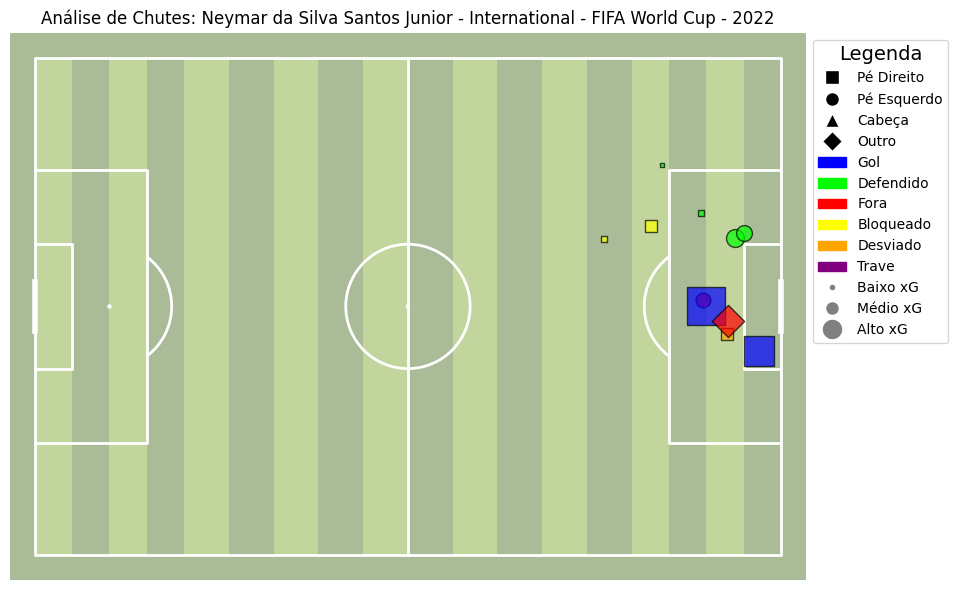

In [18]:
# Selecionando o jogo e o jogador que desejamos analisar os passes
player_shot_in_competition('Neymar da Silva Santos Junior')